# Test of class Hamiltonian_QED

!!! Qiskit version < 0.24.0 Deprecated functions not yet active. !!!

In [1]:
import qiskit

In [2]:
qiskit.__version__

'0.24.1'



This notebook uses the class in 'Hamiltonian_QED.py' that builds the Hamiltonian in terms of Pauli matrices.

The code import the class in 'HC_Lattice.py' (that defines the lattice) and then is uses the Gray encoding for gauge fields (E and U) and Jordan-Wigner formulation for fermionic degrees of freedom.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../") # go to parent dir
from itertools import permutations

In [5]:
from Hamiltonian_QED import HamiltonianQED
from HC_Lattice import HCLattice
import primme

/var/folders/08/fx8gnyrx18jggry6_s4cbtz40000gn/T/ipykernel_87233/3502893271.py:3: DeprecationWarning: Please use `aslinearoperator` from the `scipy.sparse.linalg` namespace, the `scipy.sparse.linalg.interface` namespace is deprecated.
  import primme


##### static charges

In [50]:
def func_qstatic_dist(coordlist,charge = (0,)*latt.dims):
    """Returns two lists:
    1. A list of dictionaries of the form {charge:1,j:-1} where j is the coordinate of the site to which charge is connected.
    The default is the origin (0,0,...,0) and the sites to which it is connected are the odd sites. 
    If the charge is on an odd site, then it is connected to the even sites.
    2. A list of distances between the charge and the sites to which it is connected."""
    print(charge)
    if latt.dims == 1:
        if len(charge) != 1:
            raise ValueError("Charge must be a tuple of length 1 for a 1D lattice.")
        if charge == (0,) or (charge[0]+1)%2:#even site
            distances_coord = np.array([{charge[0]:-1,j:1} for j in coordlist if j%2 and j!=charge],dtype=object)#connect (0,0) to only odd sites
        else:
            distances_coord = np.array([{charge[0]:1,j:-1} for j in coordlist if (j+1)%2 and j!=charge],dtype=object)#connect (odd,) to only even sites
    else:
        if len(charge) != latt.dims:
            raise ValueError("Charge must be a tuple of length latt.dims for a {}D lattice.".format(latt.dims))
        if charge == (0,)*latt.dims or (sum(charge)+1)%2:#even site
            distances_coord = np.array([{charge:-1,j:1} for j in coordlist if sum(j)%2 and j!=charge],dtype=object)#connect (0,0) to only odd sites
        else:
            distances_coord = np.array([{charge:1,j:-1} for j in coordlist if (sum(j)+1)%2 and j!=charge],dtype=object)
            
    def distance_f(*points):
        if len(points) < 2:
            raise ValueError("At least two points are required to calculate the distance.")
        if latt.dims == 1:
            return np.abs(points[0] - points[1])
        else:
            return np.sqrt(sum((x - y) ** 2 for x, y in zip(points[0], points[1])))


    r_list = np.empty(len(distances_coord),dtype=object)
    for i,dd in enumerate(distances_coord):
        r_list[i] =distance_f(*dd.keys())
    return distances_coord,r_list

In [51]:
func_qstatic_dist(list(latt.graph.nodes))#,charge=(1,))

(0, 0)


(array([{(0, 0): -1, (0, 1): 1}, {(0, 0): -1, (1, 0): 1}], dtype=object),
 array([1.0, 1.0], dtype=object))

In [ ]:
static_charges_values_input=[{(0,0):-1,(1,0):1},{(0,0):-1,(2,1):1},{(0,0):-1,(3,0):1},{(0,0):-1,(3,2):1}] #obc 4x3

#static_charges_values_input=[{(0,0):-1,(1,0):1},{(0,0):-1,(2,1):1},{(0,0):-1,(3,0):1},{(0,0):-1,(5,0):1},{(0,0):-1,(3,2):1},{(0,0):-1,(5,2):1}] #obc 6x3

##### new function efficient

In [22]:
import sys

In [23]:
from sympy import (
    Symbol,
    symbols,
    solve,
    lambdify,
    Mul,
    Eq,
    latex,
    expand,
    simplify,
    Pow,
    Float,
    Integer,
    cos,
)
from scipy import sparse
from sympy.core.numbers import ImaginaryUnit
from sympy.physics.quantum.dagger import Dagger
from qiskit.quantum_info import SparsePauliOp

In [11]:
from joblib import Parallel, delayed

In [12]:
def list_to_enc_hamilt2(ei , subst, ferm_lst=[], gauge_lst=[], encoding="gray",massterm=False ):#list_el
    """Return a list of Pauli operators or list of matrices (depending on the encoding used) from a list of symbolic operators.
    It consider only single operator, not entire pauli string, thus operation like (I^op^I)**2 and I^op1^I*I^op2^I are
    then simplied to I^(op**2)^I and I^(op1*op2)^I, respectively.
    Last part is put everything together and add identity matrices where needed.

    encoding: gray, ed (exact diagonalization)"""
    ham_encoded =0# np.empty(len(list_el), dtype=object)  # []
    #for kk, ei in enumerate(list_el):
    jj_mass = 0
#    for ei in list_el:
    index_op = []  # build index list order ..q2q1q0 (little endian)
    for e in ei:
        if not isinstance(
            e, (int, float, complex, Float, Integer, str, ImaginaryUnit)
        ):
            if ( list(e.free_symbols)[0].name[-1] == "D" and list(e.free_symbols)[0].name[0] == "U" ):  # gauge field U adjoint
                index_op.append( str( ( ferm_lst[::-1] + [Symbol(i.name + "D") for i in gauge_lst][::-1] ).index(*e.free_symbols) ) + "D" )
            elif ( list(e.free_symbols)[0].name[-1] == "D" and list(e.free_symbols)[0].name[0:3] == "Phi" ):  # fermion adjoint (but JW index only 0, must cover all the fermionic dof)
                index_op.append( str( ( [ Symbol(i.name + "D", commutative=False) for i in ferm_lst ][::-1] + gauge_lst[::-1] ).index(*e.free_symbols) ) + "D" )
            else:  # no adjoint
                index_op.append( str( (ferm_lst[::-1] + gauge_lst[::-1]).index( *e.free_symbols ) ) )


    symb_el = lambdify(list(zip(*subst))[0], ei)(*list(zip(*subst))[1])

    q10 = -0.5 * (class_H.I + class_H.Z)  # JW dependent
    q00 = 0.5 * (class_H.I - class_H.Z)
    sym_list_tomatrix = [(Symbol('q10OP'),q10),(Symbol('q00OP'),q00),(Symbol('EOP'),class_H.e_oper),(Symbol('UOP'),class_H.u_oper),(Symbol('UdagOP'),class_H.u_oper_dag)]
    if class_H.magnetic_basis: # U->exp(-i*alpha*E), U_dag->exp(i*alpha*E) in mag basis
        ei_class = lambda fct: class_H.matx_exp(
        fct * class_H.e_oper, 1j * class_H.alpha
    )
        sym_list_tomatrix += [(Symbol('exppiEOP'),ei_class(1)),(Symbol('expmiEOP'),ei_class(-1))]

    if not class_H.puregauge:#add fermions subst
        sym_list_tomatrix += class_H.phi_jw_list

    pauli_ei = lambdify(list(zip(*sym_list_tomatrix))[0], symb_el)(*list(zip(*sym_list_tomatrix))[1])

    op_dct = {}
    numbers = []
    ct = 0
    for ( el ) in pauli_ei:  # build dictionary of sparse pauli operators and their index
        if isinstance( el, ( SparsePauliOp, np.ndarray, sparse._csr.csr_matrix, sparse._coo.coo_matrix, ), ):
            op_dct[index_op[ct]] = el
            ct += 1
        else:
            numbers.append(el)
    if subst[0][0] == Symbol("Phi_1D", commutative=False):  # ferm
        res = ["id_f"] * len(ferm_lst) + ["id_g"] * class_H.len_e_op
        f_index_op = [
            i for i in index_op if int(re.findall("\d+", i)[0]) < len(ferm_lst)
        ]  # select only fermionic dof
        res[0] = (
            op_dct[f_index_op[0]] @ op_dct[f_index_op[1]]
        )  # compute product between fermions dof when JW applied
        start = len(ferm_lst)

    else:  # no JW
        res = ["id_q"] * len(ferm_lst) + ["id_g"] * class_H.len_e_op
        start = 0

    for i in range(start, len(res)):  # only for gauge or charges q
        if str(i) in op_dct.keys() and isinstance(
            res[i], str
        ):  # fill res with SparsePauli
            res[i] = op_dct[str(i)]
        if str(i) + "D" in op_dct.keys() and isinstance(
            res[i], str
        ):  # fill res with SparsePauli
            res[i] = op_dct[str(i) + "D"]

        if (
            isinstance(res[i], str) and res[i] == "id_q"
        ):  # remaining spots for charges are filled with I
            res[i] = class_H.I.to_matrix(sparse=False)  # single qubit for charge
        elif isinstance(res[i], str) and res[i] == "id_g":
            if encoding == "gray":
                res[i] = class_H.tensor_prod(
                    class_H.I, (class_H._n_qubits_g())
                ).to_matrix(
                    sparse=False
                )  # Gray encoding for E field
            elif (
                encoding == "ed"
            ):  # exact diagonaliz. dimensions of gauge fields 2l+1
                res[i] = sparse.eye(2 * class_H.l_par + 1,dtype=np.float32,format='csr')
    res = (
        elem for elem in res if not isinstance(elem, str)
    )  # remove id_f when JW applied

    #ham_encoded[kk] = np.prod(numbers) * class_H.pauli_tns(*res)

    # if massterm:
    #     print(((-1) ** jj_mass))
    #     ham_encoded+=((-1) ** jj_mass)* np.prod(numbers) * class_H.pauli_tns(*res)  # sum over all terms for mass hamiltonian
    #     jj_mass+=1
    # else:
    #     ham_encoded+= np.prod(numbers) * class_H.pauli_tns(*res) #sum over all terms

    return res#

In [13]:
from functools import reduce

In [14]:
class_H.hamiltonian_el_subs[10]

-6*E_20y*E_22y

In [89]:
list([list_to_enc_hamilt2(i.as_ordered_factors()  , class_H.qcharge_list + class_H.e_field_list, class_H.qop_list, class_H.eop_list, encoding=class_H.encoding, )for i in class_H.hamiltonian_el_subs][10])

[array([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]),
 array([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]),
 array([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]),
 array([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]),
 <3x3 sparse matrix of type '<class 'numpy.float32'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <3x3 sparse matrix of type '<class 'numpy.float32'>'
 	with 3 stored elements in Compressed Sparse Row format>,
 <3x3 sparse matrix of type '<class 'numpy.float32'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <3x3 sparse matrix of type '<class 'numpy.float32'>'
 	with 3 stored elements in Compressed Sparse Row format>,
 <3x3 sparse matrix of type '<class 'numpy.float32'>'
 	with 3 stored elements in Compressed Sparse Row format>]

In [90]:
def tensor_or_kron(x, y):
    if isinstance(x, SPARSE_PAULI) and isinstance(y, SPARSE_PAULI):
        return x.tensor(y)
    else:
        return sparse.kron(x, y, format="csr")

res4 = reduce(tensor_or_kron, [list_to_enc_hamilt2(i.as_ordered_factors(), class_H.qcharge_list + class_H.e_field_list, class_H.qop_list, class_H.eop_list, encoding=class_H.encoding, )for i in class_H.hamiltonian_el_subs][0])

In [91]:
res4

<3888x3888 sparse matrix of type '<class 'numpy.complex128'>'
	with 1944 stored elements in Compressed Sparse Row format>

In [92]:
SPARSE_PAULI = qiskit.quantum_info.operators.symplectic.sparse_pauli_op.SparsePauliOp
from functools import reduce
def pauli_tns(*args):
    """Returns Pauli tensor product of all arguments. If int in args then it skips it.
    If all arguments are SparsePauliOp then it applies tensor method of SparsePauliOp.
    If not it applies kronecker product of numpy.(it works also with SparsePauliOp) but much slower.)
    """
    valid_args = [arg for arg in args if not isinstance(arg, int)]

    if len(valid_args) >= 2:
        if all(
            [type(arg) == SPARSE_PAULI for arg in valid_args]
        ):  # all SparsePauliOp
            return reduce(lambda x, y: x.tensor(y), valid_args)
        else:
            return reduce(
                lambda x, y: sparse.kron(
                    x, y, format="csr"
                ),
                valid_args,
            )
    elif len(valid_args) == 1:
        return valid_args[0]
    else:
        raise ValueError("Insufficient valid arguments for tensor product")


In [93]:
res1 = pauli_tns(*[list_to_enc_hamilt2(i.as_ordered_factors()  , class_H.qcharge_list + class_H.e_field_list, class_H.qop_list, class_H.eop_list, encoding=class_H.encoding, )for i in class_H.hamiltonian_el_subs][0])

In [95]:
res1

<3888x3888 sparse matrix of type '<class 'numpy.complex128'>'
	with 1944 stored elements in Compressed Sparse Row format>

In [99]:
sparse.kron(class_H.I)

TypeError: kron() missing 1 required positional argument: 'B'

In [96]:
SPARSE_PAULI = qiskit.quantum_info.operators.symplectic.sparse_pauli_op.SparsePauliOp
from functools import reduce
def pauli_tns2(*args):
    valid_args = (arg for arg in args if not isinstance(arg, int))
    try:
        first_arg = next(valid_args)
    except StopIteration:
        raise ValueError("Insufficient valid arguments for tensor product")

    if all(isinstance(arg, SPARSE_PAULI) for arg in valid_args):
        return reduce(lambda x, y: x.tensor(y), [first_arg, *valid_args])
    else:
        return reduce(lambda x, y: sparse.kron(x, y, format="csr"), [first_arg, *valid_args])

In [97]:
res2 = pauli_tns2(*[list_to_enc_hamilt2(i.as_ordered_factors()  , class_H.qcharge_list + class_H.e_field_list, class_H.qop_list, class_H.eop_list, encoding=class_H.encoding, )for i in class_H.hamiltonian_el_subs][0])

In [98]:
res2

<1944x1944 sparse matrix of type '<class 'numpy.complex128'>'
	with 972 stored elements in Compressed Sparse Row format>

In [52]:
import scipy.sparse as sparse
from functools import reduce
from qiskit.quantum_info import SparsePauliOp
from itertools import tee

def pauli_tns3(*args):
    """Returns Pauli tensor product of all arguments. If int in args then it skips it.
    If all arguments are SparsePauliOp then it applies tensor method of SparsePauliOp.
    If not it applies kronecker product of numpy.(it works also with SparsePauliOp) 
    but for hardware device we probably not need sparse matrices.)"""
    valid_args, tensor_args = tee((arg for arg in args if not isinstance(arg, int)))

    if len(list(valid_args)) >= 2:
        if all(isinstance(arg, SparsePauliOp) for arg in valid_args):
            return reduce(lambda x, y: x.tensor(y), tensor_args)
        else:
            return reduce(lambda x, y: sparse.kron(x, y, format="csr"), tensor_args)
    elif len(list(valid_args)) == 1:
        return next(valid_args)
    else:
        raise ValueError("Insufficient valid arguments for tensor product")


In [61]:
res3 = pauli_tns3(*[list_to_enc_hamilt2(i.as_ordered_factors()  , class_H.qcharge_list + class_H.e_field_list, class_H.qop_list, class_H.eop_list, encoding=class_H.encoding, )for i in class_H.hamiltonian_el_subs][0])

QiskitError: 'Invalid input data for Pauli.'

In [57]:
res3-res4

<3888x3888 sparse matrix of type '<class 'numpy.complex128'>'
	with 0 stored elements in Compressed Sparse Row format>

In [18]:
def kron_product(matrices):
    def kron_wrapper(a, b):
        return sparse.kron(a, b, format="csr")
    
    return reduce(kron_wrapper, matrices)

In [12]:
kron_product([list_to_enc_hamilt2(i.as_ordered_factors(), class_H.qcharge_list + class_H.e_field_list, class_H.qop_list, class_H.eop_list, encoding=class_H.encoding, )for i in class_H.hamiltonian_el_subs][0])

NameError: name 'kron_product' is not defined

In [186]:
(i.as_ordered_factors() for i in class_H.hamiltonian_el_subs )
ei = [class_H.decompose_expression(i) for i in class_H.hamiltonian_el_subs][0]

In [247]:

# Parallelize the for loop using joblib
results3 = Parallel()(delayed(list_to_enc_hamilt2)(item, class_H.qcharge_list + class_H.e_field_list, class_H.qop_list, class_H.eop_list, encoding=class_H.encoding) for item in (class_H.decompose_expression(i) for i in class_H.hamiltonian_el_subs))


In [231]:

# Parallelize the for loop using joblib
results = Parallel()(delayed(list_to_enc_hamilt2)(item.as_ordered_factors(), class_H.qcharge_list + class_H.e_field_list, class_H.qop_list, class_H.eop_list, encoding=class_H.encoding) for item in class_H.hamiltonian_el_subs)


In [46]:
import multiprocessing 
from functools import partial

In [52]:
pool = multiprocessing.Pool()

with Pool() as pool:
    partial_func = partial(list_to_enc_hamilt2, class_H.qcharge_list + class_H.e_field_list, class_H.qop_list, class_H.eop_list, encoding=class_H.encoding)

    result = pool.map(partial_func, [class_H.decompose_expression(i) for i in class_H.hamiltonian_el_subs])


Process SpawnPoolWorker-125:
Process SpawnPoolWorker-126:
Process SpawnPoolWorker-127:
Traceback (most recent call last):
  File "/Users/crippa/opt/anaconda3/envs/qiskit/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/crippa/opt/anaconda3/envs/qiskit/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/crippa/opt/anaconda3/envs/qiskit/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/crippa/opt/anaconda3/envs/qiskit/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'list_to_enc_hamilt2' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "/Users/crippa/opt/anaconda3/envs/qiskit/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/crippa/opt/anaconda3/envs/qiskit/lib/python3.9/multi

KeyboardInterrupt: 

##### Memory functions

>>> 3^10*2*64/8/1000/1000/1000
.00094478400000000000
>>> 7^10*2*64/8/1000/1000/1000
4.51960398400000000000
>>> 

In [47]:
(2*l+1)**10*16/1000**3

0.15625

In [37]:
def estimate_sparse_matrix_memory(rows, nnz):
    index_size = 4  #int
    value_size = 8  #float
    
    # Memory required for non-zero indices and values
    data_memory = nnz * (index_size + value_size)
    
    # Memory required for row pointers
    row_ptr_memory = (rows + 1) * index_size
    
    # Total memory
    total_memory = data_memory + row_ptr_memory
    
    return total_memory

In [38]:
#memory sparse matrix
print((Hamiltonian_Pauli_tot.data.nbytes + Hamiltonian_Pauli_tot.indptr.nbytes + Hamiltonian_Pauli_tot.indices.nbytes)/1000**3)

1.467249992


In [39]:
estimate_sparse_matrix_memory((2*l+1)**10,Hamiltonian_Pauli_tot.count_nonzero())/1000**3

1.467249992

In [23]:
# def memory_func():
#     gauge_indep = len(latt.graph.edges)- (len(latt.graph.nodes)-1)
#     print('number of active gauge links after Gauss law applied:', gauge_indep)


#     #ED
#     if puregauge:
#         ed_size_row = (2*l+1)**(len(latt.graph.edges)- (len(latt.graph.nodes)-1))
#     else :
#         ed_size_row = (2*l+1)**(len(latt.graph.edges)- (len(latt.graph.nodes)-1))*2**len(latt.graph.nodes)
#     ferm_states = 0 if puregauge else len(set(permutations('0'*(latt.n_sitestot//2)+'1'*(latt.n_sitestot//2))))
#     nonzero_el = ((2*l+1)*gauge_indep+ferm_states)
#     print(f'Rough estimation of memory needed for sparse Hamiltonian {ed_size_row}x{ed_size_row}, ed. encoding for gauge fields and 0-charge sector for fermions')
#     print('ed',estimate_sparse_matrix_memory(ed_size_row,nonzero_el**2)/10**9,'Gb')

#     #GRAY
#     if puregauge:
#         size_row = (np.ceil(np.log2(2*l+1))*gauge_indep)  
#         #print(f'{gauge_indep} gauge fields: {np.ceil(np.log2(2*l+1))} bits for every gauge field')
#     else :
#         size_row = (len(latt.graph.nodes)+np.ceil(np.log2(2*l+1))*gauge_indep)
#         #print(f'{gauge_indep} gauge fields: {np.ceil(np.log2(2*l+1))} bits for every gauge field, fermions:{len(latt.graph.nodes)}  bits for every site')
#     ferm_states = 0 if puregauge else len(set(permutations('0'*(latt.n_sitestot//2)+'1'*(latt.n_sitestot//2))))
#     nonzero_el = ((2*l+1)*gauge_indep+ferm_states)
#     print(f'Rough estimation of memory needed for sparse Hamiltonian 2^{size_row}x2^{size_row}, Gray encoding for gauge fields and 0-charge sector for fermions ({nonzero_el}):\n',
#     estimate_sparse_matrix_memory(2**size_row,nonzero_el**2)/10**9,'Gb')

#     return

# memory_func()

number of active gauge links after Gauss law applied: 10
Rough estimation of memory needed for sparse Hamiltonian 9765625x9765625, ed. encoding for gauge fields and 0-charge sector for fermions
ed 0.039112504 Gb
Rough estimation of memory needed for sparse Hamiltonian 2^30.0x2^30.0, Gray encoding for gauge fields and 0-charge sector for fermions (50):
 4.2950173 Gb


In [19]:

def memory_array_fromshape(tupl,type_=np.float64):
    """return the memory in GiB of a dense array with shape tupl"""
    #exaple (3645236616,) *8/1024**3 #27.2 GiB
    #result in GiB
    if type_==np.float64 or type_==np.int64:
        return  np.prod(tupl)*8/1024**3
    elif type_==np.complex128:
        return  np.prod(tupl)*16/1024**3
    
memory_array_fromshape((3645236616,)) #27.2 GiB

27.159129202365875

##### Class Hamilt

In [464]:
#class input parameters:
n_sites = [2,3]#how many sites for every dimension
g=0.1
fact_e_op = 1
fact_b_op = 1
m=3
omega=1
l=1
L=8
rotors = False
lambd = 1000
encoding = 'ed'#'gray' #
magnetic_basis=True
pbc=False
puregauge = True 
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign 

#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 3

In [465]:
latt = HCLattice(n_sites,pbc=pbc)


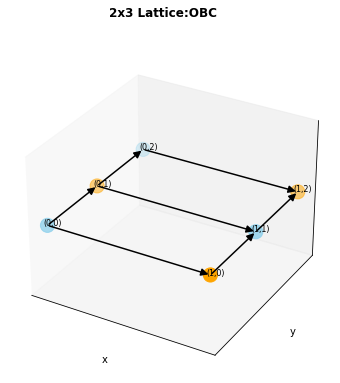

In [466]:
#TODO: in this case no conditions applied
latt.draw_graph_func(gauss_law_fig=False,static_charges=static_charges_values)
#only dynamical fields after Gauss law applied
#latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H.e_op_free)#,savefig_dir='.')

In [467]:
#latt.func_qstatic_dist()#ch_val=1)
#[latt.draw_graph_func(gauss_law_fig=False,static_charges=st ) for st in latt.distances_coord]#,savefig_dir='.')

In [468]:
class_H = HamiltonianQED(
                        latt,
                        n_sites,
                        l,
                        ll=L,
                        encoding = encoding,
                        rotors=rotors,
                        magnetic_basis=magnetic_basis,
                        pbc=pbc,
                        puregauge=puregauge,
                        static_charges_values=static_charges_values,
                        e_op_out_plus = e_op_out_plus,
                        display_hamiltonian=display_hamiltonian)

HamiltonianQED: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
> Pauli strings built
Magnetic basis used for electric H
Hamiltonian B mag basis: done
>> Gauss law applied and Hamiltonian built.  Execution time: 27.312903881072998 seconds
>> Suppression term built.  Execution time: 0.0002741813659667969 seconds


In [11]:
def sparse_mem2(sparsem):
    """Return the memory in GiB of a sparse matrix"""
    return (sparsem.data.nbytes + sparsem.indptr.nbytes + sparsem.indices.nbytes)/1024**3

##### lattice and ED spectrum

In [11]:
#NEW PAULI rules:
#SparsePauliOp @ only with other SparsePauliOp
#Pauli @ only with other Pauli
# tensor ^ only between Pauli not with numbers like before that I^2 ==II . not working anymore

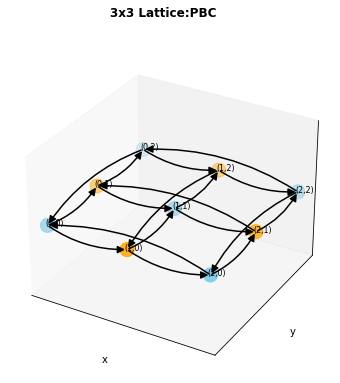

In [12]:
latt.draw_graph_func(gauss_law_fig=False)#,savefig_dir='.')

In [31]:
import scipy.sparse as sp

In [472]:
Hamiltonian_Pauli_tot = class_H.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)
#memory sparse matrix
print((Hamiltonian_Pauli_tot.data.nbytes + Hamiltonian_Pauli_tot.indptr.nbytes + Hamiltonian_Pauli_tot.indices.nbytes)/1000**3,'Gb')
if encoding=='gray':
    Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot#.to_matrix(sparse=True)
    h_b_sparse = class_H.hamiltonian_mag_pauli#.to_matrix(sparse=True) #plaquette
elif encoding=='ed':
    Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)
    h_b_sparse =sp.csr_matrix(class_H.hamiltonian_mag_pauli)
#spectrum, eigenvectors_matrix = eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA",ncv = 30)#
spectrum, eigenvectors_matrix =primme.eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA")#,ncv = 30)
#spectrum
idx = spectrum.argsort() 
spectrum = spectrum[idx]
eigenvectors_matrix = eigenvectors_matrix[:,idx]
print(f'Spectrum of {latt.dims}D_'+'x'.join([str(i) for i in n_sites])+f'H with mbasis{magnetic_basis}puregauge{puregauge} pbc{pbc}_g{g}_l{l}_L{L}_factE{fact_e_op}_factB{fact_b_op}_m{m}_Omega{omega}, encoding:'+encoding)
for kk,evalu in enumerate(spectrum):
        if evalu<900:# only physical states, 1000 corresponds to factor of penalty term
                print(f'E_{kk}=',round(evalu,8))

if class_H.len_e_op != 0:
    eig0cj = sp.csr_matrix(eigenvectors_matrix[:,0]).transpose().conjugate()#.conj().T
    eig0= sp.csr_matrix(eigenvectors_matrix[:,0])
    plaq = (eig0*h_b_sparse*eig0cj/len(latt.plaq_list) ).toarray()[0][0].real
    #plaq = (eig0cj.dot((h_b_sparse).dot(eig0)).real)/len(latt.plaq_list) 
    print(f'plaq={plaq}')
                
                         

1.34e-06 Gb
Spectrum of 2D_2x3H with mbasisTruepuregaugeTrue pbcFalse_g0.1_l1_L8_factE1_factB1_m3_Omega1, encoding:ed
E_0= -199.09117537
E_1= -192.51972172
E_2= -192.24965882
plaq=0.999748619699202


Spectrum of 2D_2x3H with mbasisTruepuregaugeTrue pbcFalse_g0.1_l1_L8_factE1_factB1_m3_Omega1, encoding:ed
E_0= -199.09117537
E_1= -192.51972172
E_2= -192.24965882
plaq=0.999748619699202

Spectrum of H with mbasisFalsepuregaugeTrue pbcTrue_g1_l1_factE1_factB1_m3_Omega1_TNFalse, encoding:ed
E_0= -1.0066823
E_1= -0.26964819
plaq=0.4623451128853849


Spectrum of H with mbasisFalsepuregaugeFalse pbcTrue_g1_l1_factE1_factB1_m3_Omega1_TNFalse, encoding:ed
E_0= -7.30371524
E_1= -6.55004296
E_2= -6.53959578
plaq= 0.45649020277218433

##### Test mag basis

In [50]:
from functools import reduce
n_kron  = lambda arg_list:reduce( lambda x, y: np.kron( x, y ), arg_list)

In [270]:
class_H.str_to_pauli(
                class_H._r_c()[1], class_H._n_qubits_g()
            ).to_matrix(sparse=False)

array([[-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

In [39]:
np.linalg.eig(class_H.e_oper.toarray())

(array([-2., -1.,  0.,  1.,  2.], dtype=float32),
 array([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], dtype=float32))

In [141]:
from qiskit.quantum_info import SparsePauliOp
from sympy import Symbol,symbols,solve,lambdify,Mul,Eq,latex,expand,simplify,Pow,Float,Integer,cos
from scipy import sparse

In [409]:

U_mag_subs = {
    **{
        el_uop: Symbol("E_" + el_uop.name[2:])
        for el_uop in class_H.u_op_free
    },
    **{
        el_uop: Symbol("E_" + el_uop.name[2:-1] + "m")
        for el_uop in class_H.u_op_free_dag
    },
}
hamiltonian_mag_sym = [
    [U_mag_subs.get(item, item) for item in sublst if item != 1]
    for sublst in class_H.hamiltonian_mag_subs
]
e_op_dict_mbasis = dict(class_H.e_field_list)
# compute exp(i*alpha*E)
ei_class = lambda fct: class_H.matx_exp(fct * class_H.e_oper, 1j * class_H.alpha)

hamiltonian_mag_pauli2 = []
for ei in hamiltonian_mag_sym:
    id_eop = {}#dict with position for tensor product as keys and ±1 as values
    for e in ei:
        if e in e_op_dict_mbasis.keys():
            id_eop[list(e_op_dict_mbasis.keys()).index(e)] = 1  #'p'== +
        else:
            id_eop[
                list(e_op_dict_mbasis.keys()).index(Symbol(e.name[:-1]))
            ] = -1  #'m'== -

    if class_H.sparse_pauli:


        if class_H.encoding == "gray":
            arg_cos = np.zeros(2**(class_H._n_qubits_g()*class_H.len_e_op),dtype=np.complex128)
            left_factor = lambda key: 2**(class_H._n_qubits_g()*(class_H.len_e_op-key-1))
            e_vals_eop = np.linalg.eig(class_H.e_oper.toarray())[0]
            right_factor = lambda key: 2**(class_H._n_qubits_g()*key)
        elif class_H.encoding == "ed":
            arg_cos = np.zeros((2 * class_H.l_par + 1)**class_H.len_e_op,dtype=np.complex128)
            left_factor = lambda key:(2 * class_H.l_par + 1)**(class_H.len_e_op-key-1)
            e_vals_eop = np.arange(- class_H.l_par, class_H.l_par+1)
            right_factor = lambda key:(2 * class_H.l_par + 1)**key
        else:
            raise ValueError("encoding not recognized")


        for key,val in id_eop.items():
            if key==class_H.len_e_op-1:
                arg_cos+= val*n_kron([e_vals_eop,np.ones(right_factor(key))] )
            elif key==0:
                arg_cos+= val*n_kron([np.ones(left_factor(key)),e_vals_eop] ) 
            else:   
                arg_cos+= val*n_kron([np.ones(left_factor(key)),e_vals_eop,np.ones(right_factor(key))] )

        print(np.shape(arg_cos))
        hamiltonian_mag_pauli2.append(sp.diags(np.cos(class_H.alpha*arg_cos)))
        
    else:#old method with cosE as exp(iE)+exp(-iE)/2. necessary if gray and sparse_pauli=False
        if class_H.encoding == "gray":
            idx = class_H.tensor_prod(
                class_H.I, (class_H._n_qubits_g())
            )  # Gray encoding for E field
        elif (
            class_H.encoding == "ed"
        ):  # exact diagonaliz. dimensions of gauge fields 2l+1
            idx = sparse.eye(2 * class_H.l_par + 1,format='csr')
        if len(ei) == 1:  # cos 1 operator is enough and rest is I
            
            cos1 = [
                class_H.cos_oper(ei_class(id_eop[i])) if i in id_eop else idx
                for i in range(class_H.len_e_op)[::-1]
            ]  # inverse because little endian

            hamiltonian_mag_pauli2.append(HamiltonianQED.pauli_tns(*cos1))

        else:
            # compute cosine of multiple operators cos(E1+E2+...)=e^iE1 e^iE2 ... + e^-iE1 e^-iE2 ... /2
            cosn = class_H.cos_oper(
                class_H.pauli_tns(
                    *[
                        ei_class(id_eop[i]) if i in id_eop else idx
                        for i in range(class_H.len_e_op)
                    ][min(id_eop) : max(id_eop) + 1][::-1]
                )
            )
            # combine with identities, e.g. cos(E2+E3) -> I^cos(E2+E3)^I^I (q4^q3^q2^q1^q0)
            hamiltonian_mag_pauli2.append(
                class_H.pauli_tns(
                    *[idx for i in range(class_H.len_e_op)[::-1]][
                        max(id_eop) + 1 :
                    ]
                    + [cosn]
                    + [idx for i in range(class_H.len_e_op)[::-1]][
                        : min(id_eop)
                    ]
                )
            )

(1024,)
(1024,)
(1024,)
(1024,)


<1024x1024 sparse matrix of type '<class 'numpy.complex128'>'
	with 1024 stored elements (1 diagonals) in DIAgonal format>

In [329]:
def r_c(l_par):
    symlist = ["I", "X", "Y", "Z", "Sd", "S-", "Su", "S+"]
    """Rotator-string/Electric field operator.
    Function equivalent to S_z term.
    Defined for Gray encoding"""
    n_qubits_g = int(np.ceil(np.log2(2 * l_par + 1)))
    def gray_map(l_par):
        """Gray map dictionary for a certain value of the truncation parameter l.
        for example if l = 1, it returns:{-1: '00', 0: '01', 1: '11'}"""
        ret = {}
        for i in range(0, 2 * l_par + 1):
            gray_decimal = i ^ (i >> 1)
            ret[i - l_par] = "{0:0{1}b}".format(gray_decimal, n_qubits_g)
        return ret

    states_list = list(range(-l_par, l_par + 1))  # states: -l, ..., l
    e_op_list = []
    for st_fact in states_list:
        if st_fact != 0:
            # using the fact that the superposition encoding is only for st_fact=0
            e_op_list.append(
                [
                    st_fact,
                    *HamiltonianQED._trans_map(
                        gray_map(l_par)[st_fact], gray_map(l_par)[st_fact]
                    ),
                ]
            )
    e_oper = [
        [
            v_elem[0],
            [
                f"{symlist[s_tmp]}_{n_qubits_g-i-1}"
                for i, s_tmp in enumerate(v_elem[1:])
            ],
        ]
        for v_elem in e_op_list
    ]
    e_oper_str = [
        f"{v_elem[0]} "
        + " ".join(
            f"{symlist[s_tmp]}_{n_qubits_g-i-1}"
            for i, s_tmp in enumerate(v_elem[1:])
        )
        for v_elem in e_op_list
    ]
    return e_oper, e_oper_str

In [378]:
# if sparsepauli true


if class_H.encoding == "gray":
    arg_cos = np.zeros(2**(class_H._n_qubits_g()*class_H.len_e_op),dtype=np.complex128)
    left_factor = lambda key: 2**(class_H._n_qubits_g()*(class_H.len_e_op-key-1))
    e_vals_eop = np.linalg.eig(class_H.e_oper.toarray())[0]
    right_factor = lambda key: 2**(class_H._n_qubits_g()*key)
elif class_H.encoding == "ed":
    arg_cos = np.zeros((2 * class_H.l_par + 1)**class_H.len_e_op,dtype=np.complex128)
    left_factor = lambda key:(2 * class_H.l_par + 1)**(class_H.len_e_op-key-1)
    e_vals_eop = np.arange(- class_H.l_par, class_H.l_par+1)
    right_factor = lambda key:(2 * class_H.l_par + 1)**key
else:
    raise ValueError("encoding not recognized")


for key,val in id_eop.items():
    if key==class_H.len_e_op-1:
        arg_cos+= val*n_kron([e_vals_eop,np.ones(right_factor(key))] )
    elif key==0:
        arg_cos+= val*n_kron([np.ones(left_factor(key)),e_vals_eop] ) 
    else:   
        arg_cos+= val*n_kron([np.ones(left_factor(key)),e_vals_eop,np.ones(right_factor(key))] )


test1=sp.diags(np.cos(class_H.alpha*arg_cos)).toarray()

0 1


In [383]:
class_H.pauli_tns(*cos1)

<1024x1024 sparse matrix of type '<class 'numpy.complex128'>'
	with 1024 stored elements in Compressed Sparse Row format>

In [379]:
hamiltonian_mag_pauli[0].toarray()-test1

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])

In [320]:
#TODO add this to class_H for cos and add option gray encoding

In [321]:
#only for 1 operator at pos 0
test0 =sparse.diags(np.cos(class_H.alpha*np.kron(np.ones((2 * class_H.l_par + 1)**(class_H.len_e_op-1)),np.arange(- class_H.l_par, class_H.l_par+1))))

In [322]:
test0-test1

matrix([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])

In [112]:
n_kron([np.ones(8),np.array([ 5.,  2.])])#*sp.eye(4)

array([5., 2., 5., 2., 5., 2., 5., 2., 5., 2., 5., 2., 5., 2., 5., 2.])

In [84]:
n_kron([np.ones(2),np.array([ 5.,  2.])])*np.eye(4) #right quante volte si ripete ogni val in array/ left quanto volte si ripete tutto l'array

array([[5., 0., 0., 0.],
       [0., 2., 0., 0.],
       [0., 0., 5., 0.],
       [0., 0., 0., 2.]])

##### cProfile

In [9]:
from memory_profiler import profile,memory_usage
#use this in class and put @profile on top of function that you want to profile

In [10]:
print('Maximum memory usage: %s' % max(memory_usage(class_H.build_hamiltonian_tot)))

list_to_enc_hamilt [] [E_12y, E_11y, E_10y, E_02y, E_20x, E_22y, E_22x, E_21y, E_20y, E_21x]
list_to_enc_hamilt [] [U_12y, U_11y, U_10y, U_02y, U_20x, U_22y, U_22x, U_21y, U_20y, U_21x]
Maximum memory usage: 3111.671875


In [221]:
import cProfile,sys

In [222]:
sys.getsizeof(class_H.get_hamiltonian())

48

In [223]:
# Create an instance of the cProfile.Profile class
profiler = cProfile.Profile()

# Enable the profiler
profiler.enable()

# Create an instance of the class
class_H = HamiltonianQED(
                        latt,
                        n_sites,
                        l,
                        ll=L,
                        encoding = encoding,
                        rotors=rotors,
                        magnetic_basis=magnetic_basis,
                        pbc=pbc,
                        puregauge=puregauge,
                        static_charges_values=static_charges_values,
                        e_op_out_plus = e_op_out_plus,
                        display_hamiltonian=display_hamiltonian,
                        tn_comparison=tn_comparison)

# Call the methods or perform operations to be profiled
import scipy.sparse as sp
Hamiltonian_Pauli_tot = class_H.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)

if encoding=='gray':
    Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot.to_matrix(sparse=True)
    h_b_sparse = class_H.hamiltonian_mag_pauli.to_matrix(sparse=True) #plaquette
elif encoding=='ed':
    Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)
    h_b_sparse =sp.csr_matrix(class_H.hamiltonian_mag_pauli)

# Disable the profiler
profiler.disable()

# Print the profiling results
profiler.print_stats(sort='time')

Alpha angle α=2 π/2L+1
HamiltonianQED: Initializing...
>> Gauss law system of equations (symbolic + latex):
static charges: ['Q_10=1', 'Q_02=-1']


Eq(-E_00x - E_00y, 0)

Eq(E_00y - E_01x - E_01y, 0)

Eq(E_01y - E_02x + 1, 0)

Eq(E_00x - E_10x - E_10y - 1, 0)

Eq(E_01x + E_10y - E_11x - E_11y, 0)

Eq(E_02x + E_11y - E_12x, 0)

Eq(E_10x - E_20y, 0)

Eq(E_11x + E_20y - E_21y, 0)

Eq(E_12x + E_21y, 0)

- E_{00x} - E_{00y} &= 0 \\ \nonumber
E_{00y} - E_{01x} - E_{01y} &= 0 \\ \nonumber
E_{01y} - E_{02x} + 1 &= 0 \\ \nonumber
E_{00x} - E_{10x} - E_{10y} - 1 &= 0 \\ \nonumber
E_{01x} + E_{10y} - E_{11x} - E_{11y} &= 0 \\ \nonumber
E_{02x} + E_{11y} - E_{12x} &= 0 \\ \nonumber
E_{10x} - E_{20y} &= 0 \\ \nonumber
E_{11x} + E_{20y} - E_{21y} &= 0 \\ \nonumber
E_{12x} + E_{21y} &= 0 

> Gauss law equations solved
> e_op_free and u_op_free built
> Pauli strings built
>> Hamiltonian (symbolic + latex):


Eq(H_E, g**2*(E_10y**2 + E_11y**2 + 2*E_20y**2 + 2*E_21y**2 + (-E_11y - E_21y)**2 + (-E_20y + E_21y)**2 + (-E_10y - E_20y - 1)**2 + (E_10y + E_20y + 1)**2 + (-E_11y - E_21y - 1)**2 + (-E_10y + E_11y - E_20y + E_21y)**2)/2)

H_{E} = \frac{g^{2} \left(E_{10y}^{2} + E_{11y}^{2} + 2 E_{20y}^{2} + 2 E_{21y}^{2} + \left(- E_{11y} - E_{21y}\right)^{2} + \left(- E_{20y} + E_{21y}\right)^{2} + \left(- E_{10y} - E_{20y} - 1\right)^{2} + \left(E_{10y} + E_{20y} + 1\right)^{2} + \left(- E_{11y} - E_{21y} - 1\right)^{2} + \left(- E_{10y} + E_{11y} - E_{20y} + E_{21y}\right)^{2}\right)}{2}


Eq(H_B, -(U_10y + U_11y + U_20y*Dagger(U_10y) + U_21y*Dagger(U_11y) + h.c.)/(2*g**2))

H_{B} = - \frac{U_{10y} + U_{11y} + U_{20y} U_{10y}^{\dagger} + U_{21y} U_{11y}^{\dagger} + h.c.}{2 g^{2}}
>> Gauss law applied and Hamiltonian built.  Execution time: 0.25234293937683105 seconds
>> Suppression term built.  Execution time: 0.061959028244018555 seconds
         327802 function calls (318851 primitive calls) in 0.318 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      174    0.034    0.000    0.034    0.000 {method 'repeat' of 'numpy.ndarray' objects}
       58    0.019    0.000    0.075    0.001 _construct.py:277(kron)
        8    0.017    0.002    0.018    0.002 linalg.py:476(inv)
6494/3381    0.013    0.000    0.056    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
     1575    0.010    0.000    0.020    0.000 {method 'reduce' of 'numpy.ufunc' objects}
      170    0.005    0.000    0.005    0.000 {method 'acquire' of '_thread.lock' objects}
      371    0.005    0.000    

In [224]:
# Create a Stats object from the profiler output
stats = pstats.Stats(profiler)
import linecache
# Sort the statistics by a specific criterion (e.g., 'tottime', 'cumtime')
stats.sort_stats('tottime')

# Print the filename, line number, and function name for each entry
for entry in stats.stats:
    filename = entry[0]
    lineno = entry[1]
    funcname = entry[2]
    
    # Get the source code line using linecache
    line = linecache.getline(filename, lineno)
    
    print(f"{filename}:{lineno}({funcname}): {line.strip()}")


NameError: name 'pstats' is not defined

##### E U for ED

Here U(Udag) is lowering(raising) operator

In [ ]:
l=1
size_op = (2*l+1)

In [ ]:
def e_ed_fun(l):
    return np.diag(np.arange(-l,l+1))

e_ed = e_ed_fun(l)

In [ ]:
def u_ed_fun(l):
    size_op = (2*l+1)
    u_ed = np.zeros((size_op,size_op))
    # Fill the upper diagonal with 1s: U
    for i in range(size_op-1):
        u_ed[i,i+1] = 1
    return u_ed

u_ed = u_ed_fun(l)

In [ ]:
from itertools import permutations
from functools import reduce

In [ ]:
def str_to_tens(string: str):
    """Transforms bitstring to tensor '0'=[1,0] and '1'=[0,1]
    for example: '00' = array([1, 0, 0, 0]) , '01' = array([0, 1, 0, 0]), '10' = array([0, 0, 1, 0]) etc.

    Parameters
    ----------
    string: sequence of 0s and 1s

    Returns
    -------
    array, result of the tensor product

    """

    return reduce(
        lambda x, y: np.kron(x, y), [[1, 0] if x == "0" else [0, 1] for x in string]
    )

In [ ]:
#onehot E |-1> |0> |1>
for el in [str_to_tens('100'),str_to_tens('010'),str_to_tens('001')]:
    print(el, (0.5*((class_H.I^class_H.I^class_H.Z)+(class_H.I^class_H.Z^class_H.Z))).to_matrix()@el)

In [ ]:
#onehot U |-1> |0> |1> #TODO NB not little endian q0^q1^q2 (like in https://arxiv.org/pdf/2008.09252.pdf)
s_p = (class_H.X+1j*class_H.Y)/2
s_m = (class_H.X-1j*class_H.Y)/2

for el in [str_to_tens('100'),str_to_tens('010'),str_to_tens('001')]:
    print(el,(((s_m^s_p^class_H.I)+(class_H.I^s_m^s_p))).to_matrix()@el)


In [ ]:
#onehot U^dag |-1> |0> |1> #TODO NB little endian q2^q1^q0
s_p = (class_H.X+1j*class_H.Y)/2
s_m = (class_H.X-1j*class_H.Y)/2

for el in [str_to_tens('100'),str_to_tens('010'),str_to_tens('001')]:
    print(el,(((class_H.I^s_p^s_m)+(s_p^s_m^class_H.I))).to_matrix()@el)


In [ ]:
def u_ed_dag_fun(l):
    u_ed_dag = np.zeros((2*l+1,2*l+1))
    # Fill the lower diagonal with 1s: U_dag
    for i in range(2*l):
        u_ed_dag[i+1,i] = 1
    return u_ed_dag

u_ed_dag =u_ed_dag_fun(l)

In [ ]:
print(np.array([1]+[0]*(2*l)) ,'\n',u_ed,u_ed@np.array([1]+[0]*(2*l)) )

In [ ]:
print(np.array([1]+[0]*(2*l)) ,'\n',u_ed_dag,u_ed_dag@np.array([1]+[0]*(2*l)) )